# Process data

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import json
import time

from keras import backend as K
import tensorflow as tf
import keras

from keras.datasets import mnist
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Dropout, Flatten, Input, Lambda, Reshape, Embedding,
                          Multiply)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [0]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# print("Before process:")
# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)

# def preprocess_imgs(x):
#       # Rescale [0, 255] grayscale pixel values to [-1, 1]
#       x = (x.astype(np.float32) - 127.5) / 127.5
#       # Expand image dimensions to width x height x channels, 28*28*1
#       x = np.expand_dims(x, axis=3)
#       return x

# def preprocess_labels(y):
#     y = y.reshape(-1, 1)
#     y = to_categorical(y, num_classes = 10)
#     return y

# x_train = preprocess_imgs(x_train)
# y_train = preprocess_labels(y_train)
# x_test = preprocess_imgs(x_test)
# y_test = preprocess_labels(y_test)

# print("After process:")
# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)

11493376/11490434 [==============================] - 1s 0us/step
Before process:
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
After process:
(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)


## Dataset

In [0]:
class Dataset:
    def __init__(self, num_labeled):

        def preprocess_imgs(x):
            # Rescale [0, 255] grayscale pixel values to [-1, 1]
            x = (x.astype(np.float32) - 127.5) / 127.5
            # Expand image dimensions to width x height x channels, 28*28*1
            x = np.expand_dims(x, axis=3)
            return x

        def preprocess_labels(y):
            y = y.reshape(-1, 1)
            y = to_categorical(y, num_classes = 10)
            return y

        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        x_train = preprocess_imgs(x_train)
        y_train = preprocess_labels(y_train)
        x_test = preprocess_imgs(x_test)
        y_test = preprocess_labels(y_test)

        # Number labeled examples to use for training
        self.num_labeled = num_labeled
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        del x_train, y_train, x_test, y_test

    def batch_labeled(self, batch_size):
        # Get a random batch of labeled images and their labels
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels

    def batch_unlabeled(self, batch_size):
        # Get a random batch of unlabeled images
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0], batch_size)
        imgs = self.x_train[idx]
        return imgs

    def training_set(self):
        return self.x_train, self.y_train

    def test_set(self):
        return self.x_test, self.y_test

## Check the data

In [0]:
# Training set

d_ytrain = {}
for i in range(10):
  d_ytrain[i] = 0
for i in range(len(y_train)):
  d_ytrain[y_train[i]] = d_ytrain.get(y_train[i]) + 1
print(d_ytrain)

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


In [0]:
# Test set

d_ytest = {}
for i in range(10):
  d_ytest[i] = 0
for i in range(len(y_test)):
  d_ytest[y_test[i]] = d_ytest.get(y_test[i]) + 1
print(d_ytest)

{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


# Number of labeled data

In [0]:
num_labeled = 100

# SCGAN-2D

In [0]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of classes in the dataset
num_classes = 10

## Build the model

In [0]:
def build_generator(z_dim):
  
    z = Input(shape=(z_dim, ))
    label = Input(shape=(num_classes, ), dtype='float32')
    label_embedding = Dense(z_dim, input_dim=num_classes)(label)
    joined_representation = Multiply()([z, label_embedding])
    
#     model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model = Dense(256 * 7 * 7, input_dim=z_dim)(joined_representation)
    model = Reshape((7, 7, 256))(model)

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(model)

    # Batch normalization
    model = BatchNormalization()(model)

    # Leaky ReLU activation
    model = LeakyReLU(alpha=0.01)(model)

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model = Conv2DTranspose(64, kernel_size=3, strides=1, padding='same')(model)

    # Batch normalization
    model = BatchNormalization()(model)

    # Leaky ReLU activation
    model = LeakyReLU(alpha=0.01)(model)

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model = Conv2DTranspose(1, kernel_size=3, strides=2, padding='same')(model)

    # Output layer with tanh activation
    conditioned_img = Activation('tanh')(model)
    
#     conditioned_img = model(joined_representation)

    model = Model([z, label], conditioned_img)

    return model

In [6]:
build_generator(z_dim).summary()












Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          1100        input_2[0][0]                    
__________________________________________________________________________________________________
multiply_1 (Multiply)           (None, 100)          0           input_1[0][0]                    
                                                                 dense_1[0][0]   

In [0]:
def build_discriminator_net(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Droupout
    model.add(Dropout(0.5))

    # Flatten the tensor
    model.add(Flatten())

    # Fully connected layer with num_classes neurons
    model.add(Dense(num_classes))

    return model

In [0]:
def build_discriminator_supervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    # Softmax activation, giving predicted probability distribution over the real classes
    model.add(Activation('softmax'))

    return model

In [0]:
def build_discriminator_unsupervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    def predict(x):
        # Transform distribution over real classes into a binary real-vs-fake probability
        prediction = 1.0 - (1.0 / (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction

    # 'Real-vs-fake' output neuron defined above
    model.add(Lambda(predict))

    return model

In [0]:
def build_gan(generator, discriminator):
    
    z = Input(shape=(z_dim, ))
    label = Input(shape=(num_classes, ))
    img = generator([z, label])
    output = discriminator(img)
    model = Model([z, label], output)

    return model

In [11]:
# Core Discriminator network:
# These layers are shared during supervised and unsupervised training

discriminator_net = build_discriminator_net(img_shape)

discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy',
                                 metrics=['accuracy'],
                                 optimizer=Adam())

discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy',
                                metrics=['accuracy'],
                                optimizer=Adam())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Build the Generator
generator = build_generator(z_dim)

discriminator_supervised.trainable = False
discriminator_unsupervised.trainable = False
gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss='binary_crossentropy', 
            metrics=['accuracy'], 
            optimizer=Adam())

In [0]:
%mkdir images

In [0]:
plot_model(generator,to_file="images/model_generator.png",show_shapes=True)

In [0]:
plot_model(discriminator_net,to_file="images/discriminator_net.png",show_shapes=True)

In [0]:
plot_model(discriminator_supervised,to_file="images/model_discriminator_supervised.png",show_shapes=True)

In [0]:
plot_model(discriminator_unsupervised,to_file="images/model_discriminator_unsupervised.png",show_shapes=True)

In [0]:
plot_model(gan,to_file="images/model_gan.png",show_shapes=True)

## Training

In [0]:
%mkdir models
%mkdir losses
%mkdir models/models-label-100
%mkdir losses/losses-label-100

In [0]:
def pretrain(iterations_pre, batch_size, save_interval):
  for iteration in range(iterations_pre):
      # imgs_labeled, labels = dataset.training_set()
      imgs_labeled, labels = dataset.batch_labeled(1000)
      loss_d_labeled_class, acc_d_labeled_class = discriminator_supervised.train_on_batch(imgs_labeled, labels)
      if (iteration + 1) % save_interval == 0:
          
          # Output training progress
          print(
              "%d [D loss class: %.4f, acc: %.2f%%]"
              % (iteration + 1, loss_d_labeled_class, 100 * acc_d_labeled_class))
          
          discriminator_supervised.save("./models/discriminator_supervised-" + str(iteration+1) + ".h5")
          
          # x, y = dataset.training_set()
          # _, accuracy = discriminator_class.evaluate(x, y)
          # print("Training Accuracy: %.2f%%" % (100 * accuracy))      

In [15]:
# Set hyperparameters
iterations_pre = 2000 # 2000
batch_size = 32
save_interval = 100

dataset = Dataset(num_labeled)

discriminator_supervised.trainable = True

pretrain(iterations_pre, batch_size, save_interval)

11493376/11490434 [==============================] - 1s 0us/step


100 [D loss class: 0.0009, acc: 100.00%]
200 [D loss class: 0.0004, acc: 100.00%]
300 [D loss class: 0.0003, acc: 100.00%]
400 [D loss class: 0.0001, acc: 100.00%]
500 [D loss class: 0.0001, acc: 100.00%]
600 [D loss class: 0.0001, acc: 100.00%]
700 [D loss class: 0.0001, acc: 100.00%]
800 [D loss class: 0.0001, acc: 100.00%]
900 [D loss class: 0.0000, acc: 100.00%]
1000 [D loss class: 0.0000, acc: 100.00%]
1100 [D loss class: 0.0000, acc: 100.00%]
1200 [D loss class: 0.0000, acc: 100.00%]
1300 [D loss class: 0.0000, acc: 100.00%]
1400 [D loss class: 0.0000, acc: 100.00%]
1500 [D loss class: 0.0000, acc: 100.00%]
1600 [D loss class: 0.0000, acc: 100.00%]
1700 [D loss class: 0.0000, acc: 100.00%]
1800 [D loss class: 0.0000, acc: 100.00%]
1900 [D loss class: 0.0000, acc: 100.00%]
2000 [D loss class: 0.0000, acc: 100.00%]


In [16]:
x, y = dataset.training_set()
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

x, y = dataset.test_set()
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

60000/60000 [==============================] - 4s 61us/step
Training Accuracy: 68.10%
10000/10000 [==============================] - 1s 62us/step
Test Accuracy: 68.32%


10000/10000 [==============================] - 1s 62us/step
0.6832


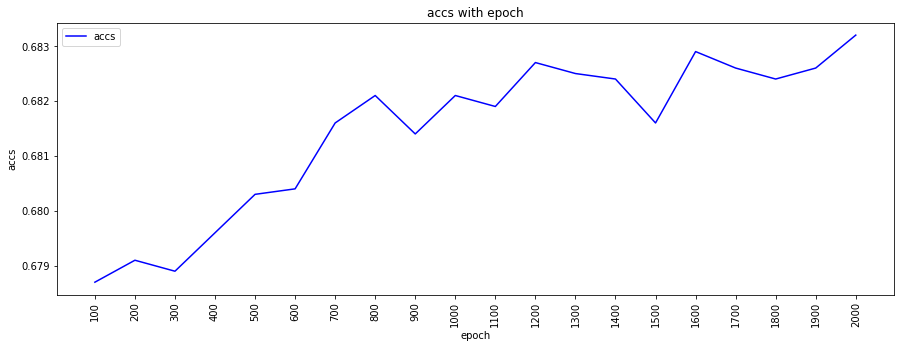

In [17]:
accs = []
tx = [x for x in range(100,2100,100)]
acc_max = [0,0]

tmodel = build_discriminator_supervised(build_discriminator_net(img_shape))
tmodel.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

for e in tx:
  tmodel.load_weights("./models/discriminator_supervised-"+ str(e) +".h5", by_name=False)
  _, acc = tmodel.evaluate(x, y)
  accs.append(acc)
print(max(accs))

plt.figure(figsize=(15, 5))
plt.plot(tx, accs, label="accs", color='blue')
plt.xticks(tx, rotation=90)
plt.title("accs with epoch")
plt.xlabel("epoch")
plt.ylabel("accs")
plt.legend()

In [0]:
def train(iterations, batch_size, save_interval, k):

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        for _ in range(k):

            # -------------------------
            #  Train the Discriminator
            # -------------------------

            # Get labeled and unlabeled examples
            imgs, labels = dataset.batch_labeled(batch_size)
            imgs_unlabeled = dataset.batch_unlabeled(batch_size)

            # Generate a batch of fake images
            z = np.random.normal(0, 1, (batch_size, z_dim))
            fake_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
            fake_labels = to_categorical(fake_labels, num_classes=num_classes)
            gen_imgs = generator.predict([z, fake_labels])

            discriminator_supervised.trainable = True
            discriminator_unsupervised.trainable = True

            loss_d_supervised, acc_d_supervised = discriminator_supervised.train_on_batch(imgs, labels) # Train on real labeled examples
            loss_d_unsupervised_real, acc_d_unsupervised_real = discriminator_unsupervised.train_on_batch(imgs_unlabeled, real) # Train on real unlabeled examples
            loss_d_unsupervised_fake, acc_d_unsupervised_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake) # Train on fake examples

            # Calculate loss and acc
            loss_d_unsupervised = 0.5 * np.add(loss_d_unsupervised_real, loss_d_unsupervised_fake)
            loss_d = np.add(loss_d_supervised, loss_d_unsupervised)
            acc_d_unsupervised = 0.5 * np.add(acc_d_unsupervised_real, acc_d_unsupervised_fake)
            acc_d = np.add(acc_d_supervised, acc_d_unsupervised)
        
        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        fake_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        fake_labels = to_categorical(fake_labels, num_classes=num_classes)
        gen_imgs = generator.predict([z, fake_labels])

        discriminator_supervised.trainable = False
        discriminator_unsupervised.trainable = False

        # Train Generator
        # loss_g_unsupervised, acc_g_unsupervised = gan.train_on_batch([z,labels], real)
        loss_g_unsupervised, acc_g_unsupervised = gan.train_on_batch([z,labels], fake)

        # Calculate loss and acc
        loss_g = loss_g_unsupervised
        acc_g = acc_g_unsupervised

        if (iteration + 1) % save_interval == 0:

            # Save losses to be plotted after training
            losses_d_supervised.append(loss_d_supervised)
            losses_d_unsupervised.append(loss_d_unsupervised)
            losses_d_unsupervised_real.append(loss_d_unsupervised_real)
            losses_d_unsupervised_fake.append(loss_d_unsupervised_fake)
            losses_d.append(loss_d)
            losses_g.append(loss_g)
            
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print(
                "%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%]"
                % (iteration + 1, 
                   loss_d_supervised, 100 * acc_d_supervised,
                   loss_d_unsupervised, 100 * acc_d_unsupervised, 
                   loss_g, 100 * acc_g))
            
            discriminator_supervised.save("./models/models-label-" + str(num_labeled) + "/discriminator_supervised-" + str(iteration+1) + ".h5")
            discriminator_unsupervised.save("./models/models-label-" + str(num_labeled) + "/discriminator_unsupervised-" + str(iteration+1) + ".h5")
            generator.save("./models/models-label-" + str(num_labeled) + "/generator-" + str(iteration+1) + ".h5")
            file1 = "./losses/losses-label-" + str(num_labeled) + "/losses_d_supervised.json"
            file2 = "./losses/losses-label-" + str(num_labeled) + "/losses_d_unsupervised.json"
            file3 = "./losses/losses-label-" + str(num_labeled) + "/losses_g.json"
            with open(file1, 'w') as json_file:
                  json.dump(str(losses_d_supervised), json_file)
            with open(file2, 'w') as json_file:
                  json.dump(str(losses_d_unsupervised), json_file)
            with open(file3, 'w') as json_file:
                  json.dump(str(losses_g), json_file)

            # x,y = dataset.training_set()
            # _, acc = discriminator_supervised.evaluate(x,y)
            # print(str(100*acc)+"%")

In [19]:
# Set hyperparameters
iterations = 8000 # 8000
batch_size = 32
save_interval = 100
k = 1 # iteration of Discriminator

losses_d_supervised = []
losses_d_unsupervised = []
losses_d_unsupervised_real = []
losses_d_unsupervised_fake = []
losses_d = []
losses_g = []

iteration_checkpoints = []

discriminator_supervised = load_model("./models/discriminator_supervised-2000.h5")
starttime = time.clock()

# Train the SCGAN-2D for the specified number of iterations
train(iterations, batch_size, save_interval, k)

endtime = time.clock()
print("Training time: %.4fs" % (endtime - starttime))

100 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0016, acc.: 100.00%] [G loss: 0.011792, acc.: 100.00%]
200 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0026, acc.: 100.00%] [G loss: 0.053192, acc.: 100.00%]
300 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0080, acc.: 100.00%] [G loss: 0.797951, acc.: 59.38%]
400 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0748, acc.: 98.44%] [G loss: 5.513861, acc.: 0.00%]
500 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0309, acc.: 98.44%] [G loss: 8.248038, acc.: 0.00%]
600 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0013, acc.: 100.00%] [G loss: 7.720906, acc.: 3.12%]
700 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.2701, acc.: 92.19%] [G loss: 3.288399, acc.: 6.25%]
800 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0838, acc.: 96.88%] [G loss: 5.014069, acc.: 0.00%]
900 [D 

## Evaluate

In [20]:
x, y = dataset.training_set()

tmodel = build_discriminator_supervised(build_discriminator_net(img_shape))
tmodel.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())
tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/discriminator_supervised-8000.h5", by_name=False)

# Compute classification accuracy on the training set
_, accuracy = tmodel.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

60000/60000 [==============================] - 4s 66us/step
Training Accuracy: 68.60%


In [21]:
x, y = dataset.test_set()

tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/discriminator_supervised-8000.h5", by_name=False)

# Compute classification accuracy on the test set
_, accuracy = tmodel.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

10000/10000 [==============================] - 1s 64us/step
Test Accuracy: 68.58%


10000/10000 [==============================] - 1s 66us/step
0.6885


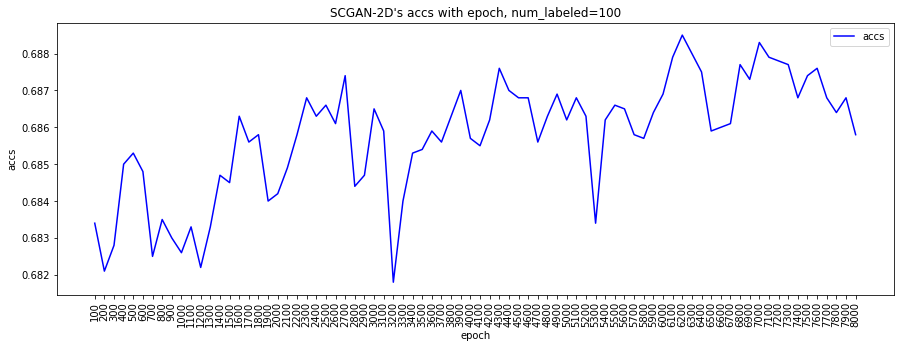

In [22]:
accs = []
tx = [x for x in range(100,8100,100)]
acc_max = [0,0]

for e in tx:
  tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/discriminator_supervised-"+ str(e) +".h5", by_name=False)
  _, acc = tmodel.evaluate(x, y)
  accs.append(acc)
print(max(accs))

plt.figure(figsize=(15, 5))
plt.plot(tx, accs, label="accs", color='blue')
plt.xticks(tx, rotation=90)
plt.title("SCGAN-2D's accs with epoch, num_labeled=%d" % num_labeled)
plt.xlabel("epoch")
plt.ylabel("accs")
plt.legend()

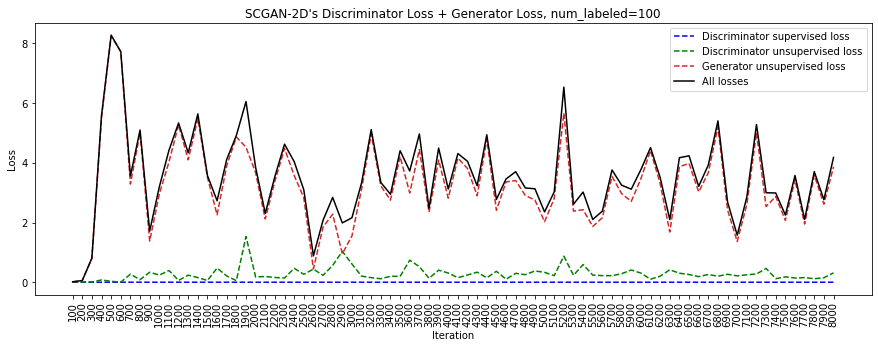

In [23]:
d_supervised_loss = np.array(losses_d_supervised)
d_unsupervised_loss = np.array(losses_d_unsupervised)
d_unsupervised_real_loss = np.array(losses_d_unsupervised_real)
d_unsupervised_fake_loss = np.array(losses_d_unsupervised_fake)
d_loss = np.array(losses_d)
g_loss = np.array(losses_g)  # Generator unsupervised loss
all_loss = np.add(d_loss, g_loss)

# Plot Discriminator supervised loss
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, d_supervised_loss, label="Discriminator supervised loss", color='blue', linestyle='dashed')
plt.plot(iteration_checkpoints, d_unsupervised_loss, label="Discriminator unsupervised loss", color='green', linestyle='dashed')
# plt.plot(iteration_checkpoints, d_unsupervised_real_loss, label="Discriminator unsupervised real loss", color='yellow')
# plt.plot(iteration_checkpoints, d_unsupervised_fake_loss, label="Discriminator unsupervised fake loss", color='yellow')
plt.plot(iteration_checkpoints, g_loss, label="Generator unsupervised loss", color='tab:red', linestyle='dashed')
plt.plot(iteration_checkpoints, all_loss, label="All losses", color='black')

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("SCGAN-2D's Discriminator Loss + Generator Loss, num_labeled=%d" % num_labeled)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

## Generate pictures

In [0]:
# gmodel = load_model("./models/models-label-" + str(num_labeled) + "/generator-7400.h5")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
# z = np.random.normal(0, 1, (batch_size, z_dim))
# fake_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
# fake_labels = to_categorical(fake_labels, num_classes=num_classes)
# gen_imgs = generator.predict([z, fake_labels])

def sample_images(image_grid_rows=2, image_grid_columns=5):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Get image labels 0-9
    fake_labels = [0,1,2,3,4,5,6,7,8,9]
    fake_labels_category = to_categorical(fake_labels, num_classes=num_classes)

    # Generate images from random noise
    gen_imgs = generator.predict([z, fake_labels_category])

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % fake_labels[cnt])
            cnt += 1

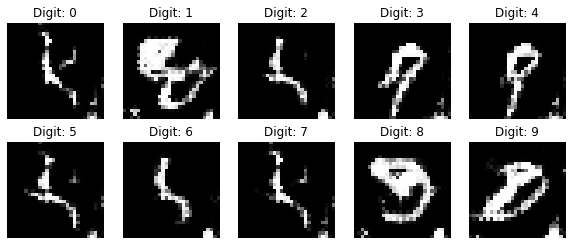

In [0]:
sample_images()

In [0]:
def sample_images_with_specified_label(label, image_grid_rows=2, image_grid_columns=5):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Get image labels 0-9
    fake_labels = [label]*10
    fake_labels_category = to_categorical(fake_labels, num_classes=num_classes)

    # Generate images from random noise
    gen_imgs = generator.predict([z, fake_labels_category])

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % fake_labels[cnt])
            cnt += 1

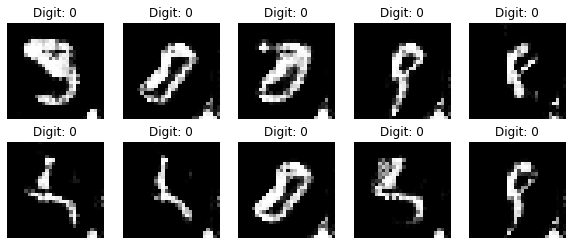

In [0]:
sample_images_with_specified_label(0)

# Pseudo Label

In [0]:
pseudo_model = build_discriminator_supervised(build_discriminator_net(img_shape))
pseudo_model.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

In [0]:
def pseudo_train(iterations, batch_size, save_interval, alpha_f, t1, t2):

    for iteration in range(iterations):

        # Get unlabeled examples and pseudo labels
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)
        pseudo_label = pseudo_model.predict(imgs_unlabeled)

        # -------------------------
        #  Supervised Training
        # -------------------------

        # Get labeled examples
        imgs_labeled, labels = dataset.batch_labeled(batch_size)

        # Train on labeled examples
        alpha = 1
        loss_labeled, acc_labeled = pseudo_model.train_on_batch(imgs_labeled, labels)

        loss_unlabeled = -1
        acc_unlabeled = -1

        # -------------------------
        #  Supervised Training
        # -------------------------

        # Set alpha
        if iteration < t1: alpha = 0
        else:
            if t1 <= iteration < t2: alpha = (iteration - t1)/(t2 - t1) * alpha_f
            else: alpha = alpha_f

            # Train on unlabeled examples
            loss_unlabeled, acc_unlabeled = pseudo_model.train_on_batch(imgs_unlabeled, pseudo_label)

        if (iteration + 1) % save_interval == 0:

          # Save losses
          losses_pseudo_labeled.append(loss_labeled)
          losses_pseudo_unlabeled.append(loss_unlabeled)
          losses_pseudo.append(loss_labeled + alpha * loss_unlabeled)
          accs_pseudo_labeled.append(acc_labeled)
          accs_pseudo_unlabeled.append(acc_unlabeled)
          accs_pseudo.append((acc_labeled + alpha*acc_unlabeled)/(1 + alpha))
          iteration_checkpoints.append(iteration + 1)

          # Output training progress
          print(
              "%d [supervised loss: %.4f, acc: %.2f%%] [unsupervised loss: %.4f, acc: %.2f%%]"
              % (iteration + 1, loss_labeled, 100 * acc_labeled, 
                  loss_unlabeled, 100 * acc_unlabeled))
          
          pseudo_model.save("./models/models-label-" + str(num_labeled) + "/pseudo-" + str(iteration+1) + ".h5")
          file1 = "./losses/losses-label-" + str(num_labeled) + "/p_supervised_losses.json"
          file2 = "./losses/losses-label-" + str(num_labeled) + "/p_unsupervised_losses.json"
          file3 = "./losses/losses-label-" + str(num_labeled) + "/p_losses.json"
          with open(file1, 'w') as json_file:
                json.dump(str(losses_pseudo_labeled), json_file)
          with open(file2, 'w') as json_file:
                json.dump(str(losses_pseudo_unlabeled), json_file)
          with open(file3, 'w') as json_file:
                json.dump(str(losses_pseudo), json_file)

In [0]:
# Set hyperparameters
iterations = 8000 # 8000
batch_size = 32
save_interval = 100
alpha_f = 3
t1 = 500 #200
t2 = 1000 # 600

losses_pseudo_labeled = []
losses_pseudo_unlabeled = []
losses_pseudo = []
accs_pseudo_labeled = []
accs_pseudo_unlabeled = []
accs_pseudo = []
iteration_checkpoints = []

dataset = Dataset(num_labeled)
discriminator_class.trainable = True

starttime = time.clock()

# Train the SGGAN for the specified number of iterations
pseudo_train(iterations, batch_size, save_interval, alpha_f, t1, t2)

endtime = time.clock()
print("Training time: %.4fs" % (endtime - starttime))

100 [supervised loss: 0.4110, acc: 93.75%] [unsupervised loss: -1.0000, acc: -100.00%]
200 [supervised loss: 0.0904, acc: 96.88%] [unsupervised loss: -1.0000, acc: -100.00%]
300 [supervised loss: 0.0430, acc: 100.00%] [unsupervised loss: -1.0000, acc: -100.00%]
400 [supervised loss: 0.0401, acc: 100.00%] [unsupervised loss: -1.0000, acc: -100.00%]
500 [supervised loss: 0.0285, acc: 100.00%] [unsupervised loss: -1.0000, acc: -100.00%]
600 [supervised loss: 0.0708, acc: 96.88%] [unsupervised loss: 0.2341, acc: 90.62%]
700 [supervised loss: 0.0638, acc: 100.00%] [unsupervised loss: 0.1348, acc: 93.75%]
800 [supervised loss: 0.0409, acc: 100.00%] [unsupervised loss: 0.0492, acc: 100.00%]
900 [supervised loss: 0.1363, acc: 93.75%] [unsupervised loss: 0.4162, acc: 87.50%]
1000 [supervised loss: 0.0075, acc: 100.00%] [unsupervised loss: 0.2076, acc: 93.75%]
1100 [supervised loss: 0.0439, acc: 96.88%] [unsupervised loss: 0.1024, acc: 96.88%]
1200 [supervised loss: 0.0064, acc: 100.00%] [unsupe

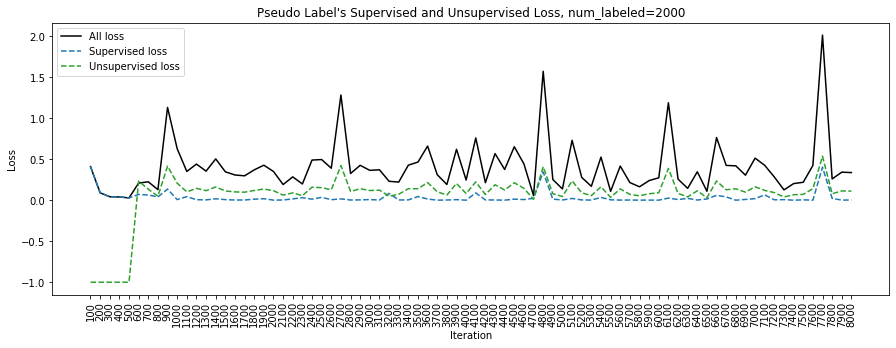

In [0]:
plot_pseudo_supervised_losses = np.array(losses_pseudo_labeled)
plot_pseudo_unsupervised_losses = np.array(losses_pseudo_unlabeled)
plot_pseudo_all_losses = np.array(losses_pseudo)

# Plot losses
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, plot_pseudo_all_losses, label="All loss", color='black')
plt.plot(iteration_checkpoints, plot_pseudo_supervised_losses, label="Supervised loss", color='tab:blue', linestyle='dashed')
plt.plot(iteration_checkpoints, plot_pseudo_unsupervised_losses, label="Unsupervised loss", color='tab:green', linestyle='dashed')

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Pseudo Label's Supervised and Unsupervised Loss, num_labeled=%d" % num_labeled)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

In [0]:
x, y = dataset.training_set()

# tmodel = load_model("./models/models-label-" + str(num_labeled) + "/pseudo-8000.h5")
tmodel = build_discriminator_supervised(build_discriminator_net(img_shape))
tmodel.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())
tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/pseudo-8000.h5", by_name=False)

# Compute classification accuracy on the training set
_, accuracy = tmodel.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

60000/60000 [==============================] - 6s 103us/step
Training Accuracy: 95.85%


In [0]:
x, y = dataset.test_set()

# tmodel = load_model("./models/models-label-" + str(num_labeled) + "/pseudo-6000.h5")
tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/pseudo-5900.h5", by_name=False)

_, accuracy = tmodel.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

10000/10000 [==============================] - 1s 82us/step
Test Accuracy: 96.04%


10000/10000 [==============================] - 1s 88us/step
0.9668


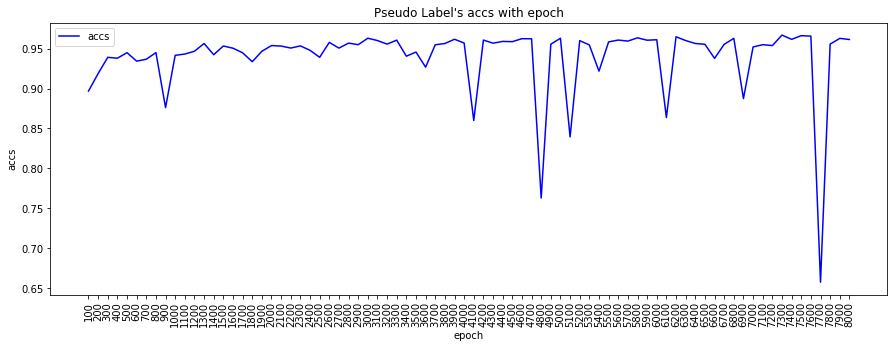

In [0]:
accs = []
tx = [x for x in range(100,8100,100)]
acc_max = [0,0]

for e in tx:
  # tmodel = load_model("./models/models-label-" + str(num_labeled) + "/pseudo-"+ str(e) +".h5")
  tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/pseudo-"+ str(e) +".h5", by_name=False)
  _, acc = tmodel.evaluate(x, y)
  accs.append(acc)
print(max(accs))

plt.figure(figsize=(15, 5))
plt.plot(tx, accs, label="accs", color='blue')
plt.xticks(tx, rotation=90)
plt.title("Pseudo Label's accs with epoch")
plt.xlabel("epoch")
plt.ylabel("accs")
plt.legend()

In [0]:
for acc in accs:
  print(acc)

0.9562
0.9245
0.9482
0.9531
0.9487
0.9533
0.9543
0.9567
0.9552
0.9569
0.9527
0.9556
0.9572
0.9576
0.9569
0.9572
0.9559
0.9565
0.9522
0.9574
0.9593
0.9484
0.9522
0.9543
0.9551
0.9545
0.9553
0.9534
0.9514
0.9574
0.9562
0.9556
0.9533
0.9596
0.9604
0.9572
0.9362
0.9547
0.9565
0.9539
0.9544
0.955
0.9558
0.9585
0.9578
0.9561
0.9531
0.9578
0.9529
0.958
0.9504
0.9576
0.9479
0.9582
0.9558
0.9567
0.9487
0.9465
0.95
0.9575
0.9545
0.9582
0.9598
0.9564
0.9579
0.9599
0.9604
0.9604
0.958
0.9564
0.9533
0.9551
0.9542
0.9609
0.9499
0.9573
0.9592
0.9582
0.9506
0.9571


# Mean Teacher

In [0]:
student = build_discriminator_supervised(build_discriminator_net(img_shape))
teacher = build_discriminator_supervised(build_discriminator_net(img_shape))
student.compile(loss='categorical_crossentropy', 
                metrics=['accuracy'], 
                optimizer=Adam())
teacher.compile(loss='categorical_crossentropy', 
                metrics=['accuracy'], 
                optimizer=Adam())

In [0]:
def mean_teacher_train(iterations, batch_size, save_interval, alpha):

    for iteration in range(iterations):

        # -------------------------
        #  Train the model
        # -------------------------

        # Get labeled examples
        imgs_labeled, labels = dataset.batch_labeled(batch_size)

        # Get unlabeled examples
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)

        # Train on labeled examples
        loss_labeled_classification, acc_labeled_classification = student.train_on_batch(imgs_labeled, labels)
        pred_teacher_labeled = teacher.predict(imgs_labeled)
        loss_labeled_consistency, acc_labeled_consistency = student.train_on_batch(imgs_labeled, pred_teacher_labeled)

        # Train on unlabeled examples
        pred_teacher_unlabeled = teacher.predict(imgs_unlabeled)
        loss_unlabeled_consistency, acc_unlabeled_consistency = student.train_on_batch(imgs_unlabeled, pred_teacher_unlabeled)

        # Update teacher model
        teacher_weights_this = teacher.get_weights()
        student_weights_this = student.get_weights()
        for i in range(len(teacher_weights_this)):
          teacher_weights_this[i] = alpha * teacher_weights_this[i] + (1-alpha) * student_weights_this[i]
        # teacher_weights_this = alpha * teacher_weights_this + (1-alpha) * student_weights_this
        teacher_weights_last = teacher_weights_this
        teacher.set_weights(teacher_weights_this)

        if (iteration + 1) % save_interval == 0:

          # Save losses
          supervised_losses.append(loss_labeled_classification)
          unsupervised_losses.append(loss_labeled_consistency + loss_unlabeled_consistency)
          labeled_consistency_costs.append(loss_labeled_consistency)
          unlabeled_consistency_costs.append(loss_unlabeled_consistency)
          accs_supervised.append(acc_labeled_classification)
          accs_unsupervised.append((acc_labeled_consistency + acc_unlabeled_consistency)/2.0)
          accs_labeled_consistency.append(acc_labeled_consistency)
          accs_unlabeled_consistency.append(acc_unlabeled_consistency)

          iteration_checkpoints.append(iteration + 1)

          # Output training progress
          print(
              "%d [supervised loss: %.4f, acc: %.2f%%] [unsupervised loss: %.4f, acc: %.2f%%] [labeled consistency loss: %.4f, acc:acc: %.2f%%] [unlabeled consistency loss: %.4f, acc: %.2f%%]"
              % (iteration + 1, loss_labeled_classification, 100 * acc_labeled_classification, 
                 loss_labeled_consistency + loss_unlabeled_consistency, 100 * ((acc_labeled_consistency + acc_unlabeled_consistency)/2.0), 
                 loss_labeled_consistency, 100 * acc_labeled_consistency, 
                  loss_unlabeled_consistency, 100 * acc_unlabeled_consistency))
          
          student.save("./models/models-label-" + str(num_labeled) + "/student-" + str(iteration+1) + ".h5")
          teacher.save("./models/models-label-" + str(num_labeled) + "/teacher-" + str(iteration+1) + ".h5")
          file1 = "./losses/losses-label-" + str(num_labeled) + "/mt_supervised_losses.json"
          file2 = "./losses/losses-label-" + str(num_labeled) + "/mt_unsupervised_losses.json"
          file3 = "./losses/losses-label-" + str(num_labeled) + "/mt_labeled_consistency_costs.json"
          file4 = "./losses/losses-label-" + str(num_labeled) + "/mt_unlabeled_consistency_costs.json"
          with open(file1, 'w') as json_file:
                json.dump(str(supervised_losses), json_file)
          with open(file2, 'w') as json_file:
                json.dump(str(unsupervised_losses), json_file)
          with open(file3, 'w') as json_file:
                json.dump(str(labeled_consistency_costs), json_file)
          with open(file4, 'w') as json_file:
                json.dump(str(unlabeled_consistency_costs), json_file)

In [0]:
# Set hyperparameters
iterations = 8000 # 8000
batch_size = 32
save_interval = 100
alpha = 0.5

supervised_losses = [] # classification cost
unsupervised_losses = [] # consistency cost
labeled_consistency_costs = []
unlabeled_consistency_costs = []
accs_supervised = []
accs_unsupervised = []
accs_labeled_consistency = []
accs_unlabeled_consistency = []
iteration_checkpoints = []

dataset = Dataset(num_labeled)
discriminator_class.trainable = True

starttime = time.clock()

# Train the mean teacher for the specified number of iterations
mean_teacher_train(iterations, batch_size, save_interval, alpha)

endtime = time.clock()
print("Training time: %.4fs" % (endtime - starttime))

100 [supervised loss: 0.0538, acc: 100.00%] [unsupervised loss: 0.6752, acc: 93.75%] [labeled consistency loss: 0.1867, acc:acc: 100.00%] [unlabeled consistency loss: 0.4885, acc: 87.50%]
200 [supervised loss: 0.5638, acc: 87.50%] [unsupervised loss: 0.8081, acc: 92.19%] [labeled consistency loss: 0.4923, acc:acc: 90.62%] [unlabeled consistency loss: 0.3158, acc: 93.75%]
300 [supervised loss: 0.0542, acc: 96.88%] [unsupervised loss: 0.3811, acc: 93.75%] [labeled consistency loss: 0.1144, acc:acc: 100.00%] [unlabeled consistency loss: 0.2667, acc: 87.50%]
400 [supervised loss: 0.0389, acc: 100.00%] [unsupervised loss: 0.2144, acc: 100.00%] [labeled consistency loss: 0.1075, acc:acc: 100.00%] [unlabeled consistency loss: 0.1069, acc: 100.00%]
500 [supervised loss: 0.0317, acc: 100.00%] [unsupervised loss: 0.3266, acc: 96.88%] [labeled consistency loss: 0.0568, acc:acc: 100.00%] [unlabeled consistency loss: 0.2698, acc: 93.75%]
600 [supervised loss: 0.2984, acc: 90.62%] [unsupervised loss

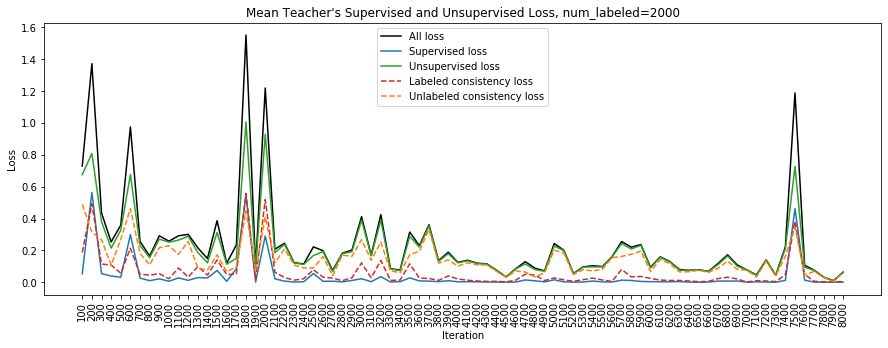

In [0]:
plot_supervised_losses = np.array(supervised_losses)
plot_unsupervised_losses = np.array(unsupervised_losses)
plot_labeled_consistency_costs = np.array(labeled_consistency_costs)
plot_unlabeled_consistency_costs = np.array(unlabeled_consistency_costs)
plot_all_losses = np.array(supervised_losses)+np.array(unsupervised_losses)

# Plot losses
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, plot_all_losses, label="All loss", color='black')
plt.plot(iteration_checkpoints, plot_supervised_losses, label="Supervised loss", color='tab:blue')
plt.plot(iteration_checkpoints, plot_unsupervised_losses, label="Unsupervised loss", color='tab:green')
plt.plot(iteration_checkpoints, plot_labeled_consistency_costs, label="Labeled consistency loss", color='tab:red', linestyle='dashed')
plt.plot(iteration_checkpoints, plot_unlabeled_consistency_costs, label="Unlabeled consistency loss", color='tab:orange', linestyle='dashed')

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Mean Teacher's Supervised and Unsupervised Loss, num_labeled=%d" % num_labeled)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

In [0]:
x, y = dataset.training_set()

tmodel = build_discriminator_supervised(build_discriminator_net(img_shape))
tmodel.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())
tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/teacher-8000.h5", by_name=False)

# Compute classification accuracy on the training set
_, accuracy = tmodel.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

60000/60000 [==============================] - 6s 108us/step
Training Accuracy: 96.39%


In [0]:
x, y = dataset.test_set()

tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/teacher-6100.h5", by_name=False)

# Compute classification accuracy on the test set
_, accuracy = tmodel.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

10000/10000 [==============================] - 1s 94us/step
Test Accuracy: 96.57%


10000/10000 [==============================] - 1s 84us/step
0.9731


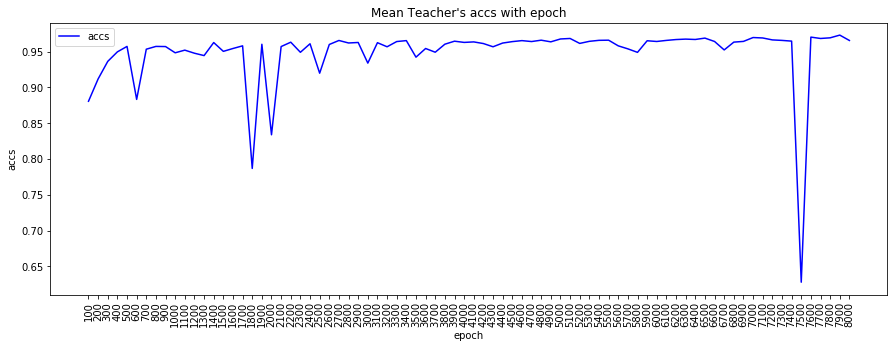

In [0]:
accs = []
tx = [x for x in range(100,8100,100)]
acc_max = [0,0]

for e in tx:
  tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/teacher-"+ str(e) +".h5", by_name=False)
  _, acc = tmodel.evaluate(x, y)
  accs.append(acc)
print(max(accs))

plt.figure(figsize=(15, 5))
plt.plot(tx, accs, label="accs", color='blue')
plt.xticks(tx, rotation=90)
plt.title("Mean Teacher's accs with epoch")
plt.xlabel("epoch")
plt.ylabel("accs")
plt.legend()

In [0]:
for acc in accs:
  print(acc)

0.8807
0.9119
0.9364
0.9497
0.9573
0.8833
0.9534
0.9573
0.9571
0.9484
0.9521
0.9478
0.9445
0.9627
0.9504
0.9544
0.9581
0.7869
0.9603
0.8339
0.9571
0.9632
0.9491
0.961
0.9199
0.96
0.9656
0.9621
0.9628
0.934
0.9625
0.9568
0.9641
0.9654
0.9423
0.9544
0.9492
0.9604
0.9646
0.9629
0.9636
0.9613
0.9568
0.962
0.964
0.9654
0.9641
0.966
0.9637
0.9677
0.9684
0.9615
0.9644
0.9658
0.966
0.9581
0.9539
0.949
0.9652
0.9642
0.9657
0.9669
0.9675
0.967
0.9689
0.9642
0.9524
0.9633
0.9643
0.9697
0.9691
0.9664
0.9657
0.9647
0.628
0.9703
0.9684
0.9693
0.9731
0.9656


# Delete

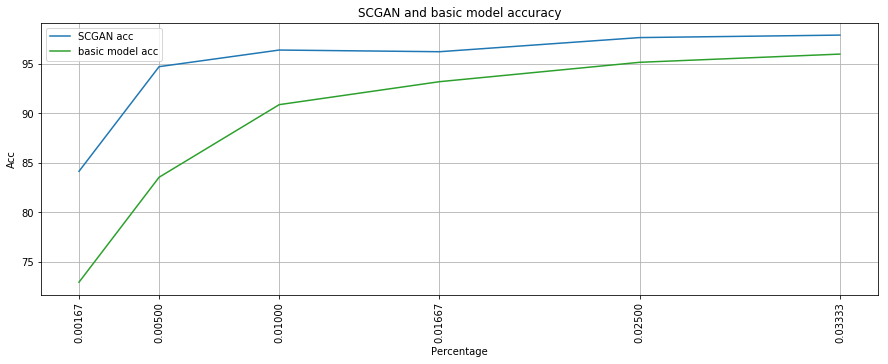

In [0]:
acc_scgan = np.array([84.15, 94.73, 96.41, 96.24, 97.67, 97.92])
acc_basic = np.array([72.94, 83.55, 90.89, 93.21, 95.17, 96.00])
per = [1/600, 1/200, 1/100, 1/60, 1/40, 1/30]
# Plot Discriminator supervised loss
plt.figure(figsize=(15, 5))
plt.plot(per, acc_scgan, label="SCGAN acc", color='tab:blue')
plt.plot(per, acc_basic, label="basic model acc", color='tab:green')

plt.xticks(per, rotation=90)

plt.title("SCGAN and basic model accuracy")
plt.xlabel("Percentage")
plt.ylabel("Acc")

plt.grid()
plt.legend()

---